FileUpload(value={}, accept='image/*', description='Upload')

Loaded 402 images.
Labels: {'Yellow', 'Green', 'Black', 'L-Yellow', 'Beige', 'D-Green', 'Blue', 'Navy', 'Grey', 'Off-White', 'Red', 'Maroon', 'Pink', 'Lilac', 'Orange', 'White', 'Purple', 'D-Pink', 'Teal', 'L-Pink', 'Rust', 'Brown', 'Coral', 'Mustard', 'Turquoise', 'Olive', 'L-Green'}


Output()

ColorPicker(value='black', description='Pick a Color:')

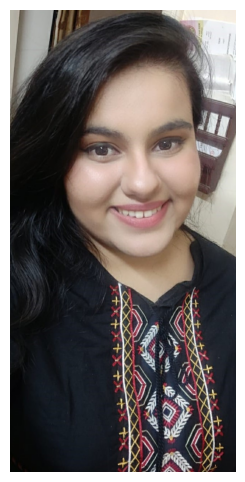

In [51]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display, clear_output
from PIL import Image
import os

# Global variables for image handling and color information
img = None
fig = None
ax = None
output = None
color_patch = None

# Global variable to store closest colors
closest_colors_storage = {}

# Color names and hex values dictionary
color_names = {
    "Beige": "#f5f5dc",
    "Black": "#000000",
    "Blue": "#0000ff",
    "Brown": "#a52a2a",
    "Coral": "#ff7f50",
    "D-Green": "#006400",
    "D-Pink": "#ff1493",
    "Green": "#008000",
    "Grey": "#808080",
    "L-Green": "#90ee90",
    "Lilac": "#c8a2c8",
    "L-Pink": "#ffb6c1",
    "L-Yellow": "#ffffe0",
    "Maroon": "#800000",
    "Mustard": "#ffdb58",
    "Navy": "#000080",
    "Off-White": "#f8f8ff",
    "Olive": "#808000",
    "Orange": "#ffa500",
    "Pink": "#ffc0cb",
    "Purple": "#800080",
    "Red": "#ff0000",
    "Rust": "#b7410e",
    "Teal": "#008080",
    "Turquoise": "#40e0d0",
    "White": "#ffffff",
    "Yellow": "#ffff00"
}

# Function to convert RGB to Hex
def rgb_to_hex(r, g, b):
    return "#{:02x}{:02x}{:02x}".format(r, g, b)

# Function to convert Hex to RGB
def hex_to_rgb(hex_string):
    hex_string = hex_string.lstrip('#')
    return tuple(int(hex_string[i:i+2], 16) for i in (0, 2, 4))

# Function to calculate Euclidean distance between two RGB colors
def rgb_distance(rgb1, rgb2):
    return np.sqrt(np.sum((np.array(rgb1) - np.array(rgb2)) ** 2))

# Function to generate a palette of similar colors based on the picked color
def generate_color_palettes(base_color):
    # Convert hex color to RGB tuple
    base_rgb = hex_to_rgb(base_color)

    # Define functions to generate color variations
    def lighten(rgb):
        return tuple(min(255, int(c * 1.2)) for c in rgb)

    def darken(rgb):
        return tuple(max(0, int(c * 0.8)) for c in rgb)

    # Generate complementary palette
    complementary_palette = [
        base_color,
        rgb_to_hex(*lighten(base_rgb)),
        rgb_to_hex(*darken(base_rgb))
    ]

    # Generate analogous palette
    analogous_palette = [
        base_color,
        rgb_to_hex(*lighten(base_rgb)),
        rgb_to_hex(*darken(base_rgb)),
        rgb_to_hex(*lighten((base_rgb[0], base_rgb[1] + 20, base_rgb[2]))),
        rgb_to_hex(*darken((base_rgb[0], base_rgb[1] + 20, base_rgb[2])))
    ]

    # Generate monochromatic palette
    monochromatic_palette = [
        base_color,
        rgb_to_hex(*lighten(base_rgb)),
        rgb_to_hex(*darken(base_rgb)),
        rgb_to_hex(*lighten((base_rgb[0], base_rgb[1] - 20, base_rgb[2] - 20))),
        rgb_to_hex(*darken((base_rgb[0], base_rgb[1] - 20, base_rgb[2] - 20)))
    ]

    # Return the palettes
    return {
        'Complementary Palette': complementary_palette,
        'Analogous Palette': analogous_palette,
        'Monochromatic Palette': monochromatic_palette
    }

# Function to handle click event on image
def on_click(event):
    global img, output, closest_colors_storage
    if img is not None:
        x, y = int(event.xdata), int(event.ydata)
        bgr_color = img[y, x]
        rgb_color = (bgr_color[2], bgr_color[1], bgr_color[0])
        hex_color = rgb_to_hex(*rgb_color)

        with output:
            clear_output(wait=True)
            print(f'Clicked Color - RGB: {rgb_color}, Hex: {hex_color}')
            palettes = generate_color_palettes(hex_color)

            # Find closest colors from the predefined color names
            closest_colors = {}
            for palette_name, colors in palettes.items():
                closest_colors[palette_name] = []
                for color_hex in colors:
                    closest_color = min(color_names.keys(), key=lambda name: rgb_distance(hex_to_rgb(color_hex), hex_to_rgb(color_names[name])))
                    closest_colors[palette_name].append((closest_color, color_names[closest_color]))

            # Store closest colors in global storage
            closest_colors_storage = closest_colors

            # Print closest colors for each palette
            for palette_name, closest_list in closest_colors.items():
                closest_colors_str = ', '.join([f'{name}: {hex}' for name, hex in closest_list])
                print(f'{palette_name}: {closest_colors_str}')

# Function to handle color change event in color picker
def on_color_change(change):
    global output, closest_colors_storage
    with output:
        clear_output(wait=True)
        picked_color_hex = change.new
        print(f'Hex: {picked_color_hex}')
        palettes = generate_color_palettes(picked_color_hex)

        # Find closest colors from the predefined color names
        closest_colors = {}
        for palette_name, colors in palettes.items():
            closest_colors[palette_name] = []
            for color_hex in colors:
                closest_color = min(color_names.keys(), key=lambda name: rgb_distance(hex_to_rgb(color_hex), hex_to_rgb(color_names[name])))
                closest_colors[palette_name].append((closest_color, color_names[closest_color]))

        # Store closest colors in global storage
        closest_colors_storage = closest_colors

        # Print closest colors for each palette
        for palette_name, closest_list in closest_colors.items():
            closest_colors_str = ', '.join([f'{name}: {hex}' for name, hex in closest_list])
            print(f'{palette_name}: {closest_colors_str}')

# Create a file upload widget
upload = widgets.FileUpload(accept='image/*', multiple=False)

# Display the upload widget
display(upload)

# Function to handle image upload
def on_upload_change(change):
    global img, fig, ax, output, color_patch
    if upload.value:
        file_info = list(upload.value.values())[0]
        content = file_info['content']

        # Decode the image
        nparr = np.frombuffer(content, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

        # Display the image using matplotlib
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')

        # Initialize output widget for displaying color values
        output = widgets.Output()
        display(output)

        # Connect the click event
        fig.canvas.mpl_connect('button_press_event', on_click)

        # Display color patch for visual feedback
        color_patch = widgets.ColorPicker(description='Pick a Color:', concise=False)
        display(color_patch)

        # Display hexadecimal color picked using color picker
        def on_color_change_wrapper(change):
            on_color_change(change)

        color_patch.observe(on_color_change_wrapper, names='value')

# Attach the handler to the upload widget
upload.observe(on_upload_change, names='value')

# Function to load images from folder
def load_images_from_folder(folder, colors):
    images = []
    labels = []
    for color in colors:
        color_path = os.path.join(folder, color)
        files = os.listdir(color_path)
        for file in files:
            img_path = os.path.join(color_path, file)
            img = Image.open(img_path)
            img_array = np.array(img)
            images.append(img_array)
            labels.append(color)
    return images, labels

# Example usage to load images from a folder
folder_path = '/content/drive/MyDrive/Khaadi'
colors = ['Beige', 'Black', 'Blue', 'Brown', 'Coral', 'D-Green', 'D-Pink', 'Green', 'Grey', 'L-Green', 'Lilac', 'L-Pink', 'L-Yellow', 'Maroon', 'Mustard', 'Navy', 'Off-White', 'Olive','Orange', 'Pink', 'Purple', 'Red', 'Rust', 'Teal', 'Turquoise', 'White', 'Yellow']
images, labels = load_images_from_folder(folder_path, colors)
print(f"Loaded {len(images)} images.")
print(f"Labels: {set(labels)}")

# Example usage to access closest colors stored in closest_colors_storage
if 'Complementary Palette' in closest_colors_storage:
    closest_complementary = closest_colors_storage['Complementary Palette']
    print(f"Closest colors in Complementary Palette: {closest_complementary}")

if 'Analogous Palette' in closest_colors_storage:
    closest_analogous = closest_colors_storage['Analogous Palette']
    print(f"Closest colors in Analogous Palette: {closest_analogous}")

if 'Monochromatic Palette' in closest_colors_storage:
    closest_monochromatic = closest_colors_storage['Monochromatic Palette']
    print(f"Closest colors in Monochromatic Palette: {closest_monochromatic}")


In [52]:
print(closest_colors_storage)

{'Complementary Palette': [('L-Pink', '#ffb6c1'), ('Beige', '#f5f5dc'), ('Grey', '#808080')], 'Analogous Palette': [('L-Pink', '#ffb6c1'), ('Beige', '#f5f5dc'), ('Grey', '#808080'), ('L-Yellow', '#ffffe0'), ('Lilac', '#c8a2c8')], 'Monochromatic Palette': [('L-Pink', '#ffb6c1'), ('Beige', '#f5f5dc'), ('Grey', '#808080'), ('Pink', '#ffc0cb'), ('Grey', '#808080')]}


In [53]:
# Initialize a list to store all color names
all_colors = []

# Iterate over closest_colors_storage and populate the list
for palette_name, closest_list in closest_colors_storage.items():
    all_colors.extend([color[0] for color in closest_list])

# Convert the list to a NumPy array
all_colors_array = np.array(all_colors)

# Print the combined array of color names
print("Combined Colors Array:", all_colors_array)


Combined Colors Array: ['L-Pink' 'Beige' 'Grey' 'L-Pink' 'Beige' 'Grey' 'L-Yellow' 'Lilac'
 'L-Pink' 'Beige' 'Grey' 'Pink' 'Grey']


In [54]:
all_colors_set = set(all_colors_array)
print(all_colors_set)

{'L-Pink', 'L-Yellow', 'Pink', 'Lilac', 'Beige', 'Grey'}


In [55]:
all_colors_array = list(all_colors_set)
print(all_colors_array)

['L-Pink', 'L-Yellow', 'Pink', 'Lilac', 'Beige', 'Grey']


Displaying images from /content/drive/MyDrive/Khaadi/L-Pink


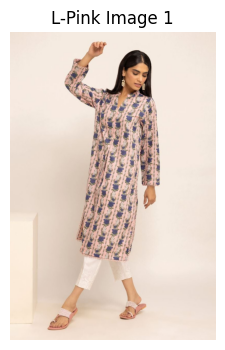

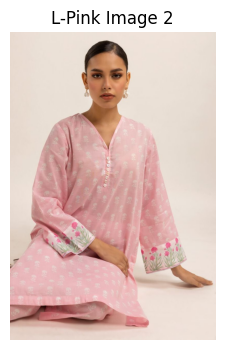

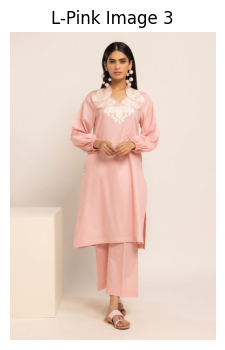

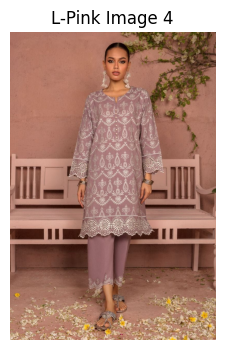

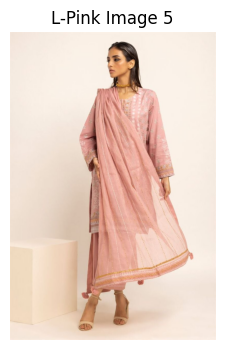

Displaying images from /content/drive/MyDrive/Khaadi/L-Yellow


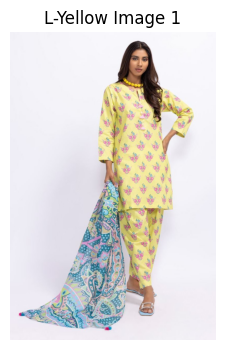

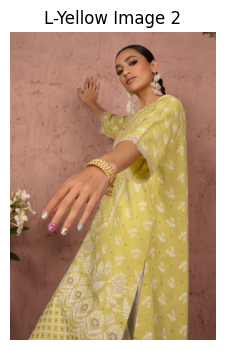

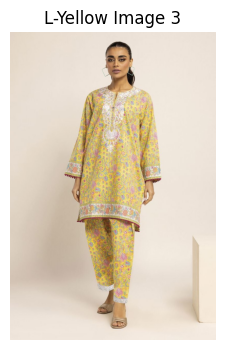

Displaying images from /content/drive/MyDrive/Khaadi/Pink


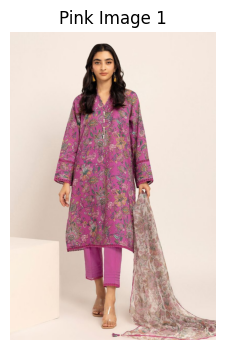

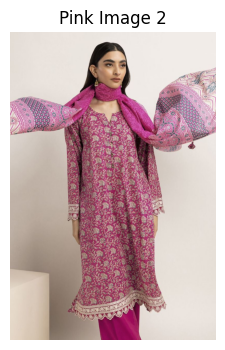

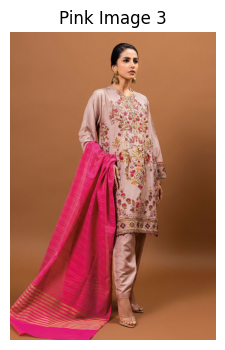

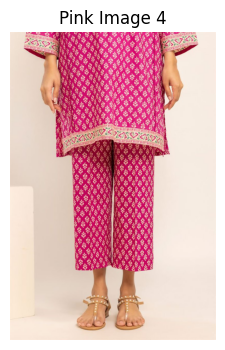

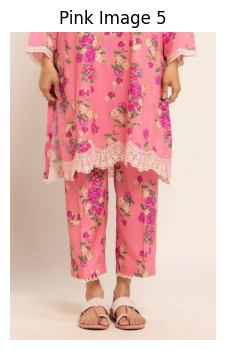

Displaying images from /content/drive/MyDrive/Khaadi/Lilac


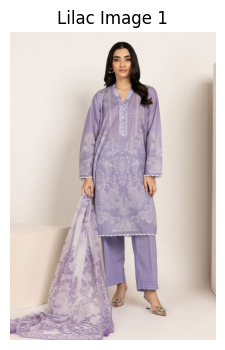

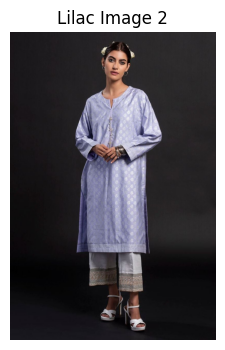

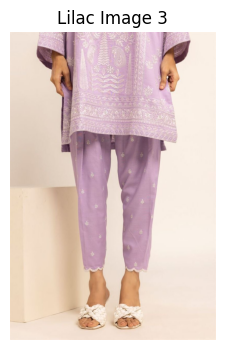

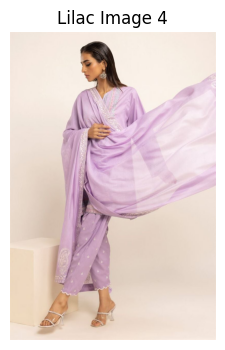

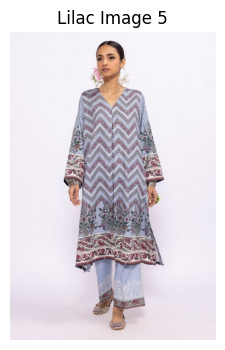

Displaying images from /content/drive/MyDrive/Khaadi/Beige


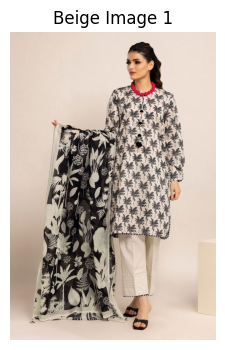

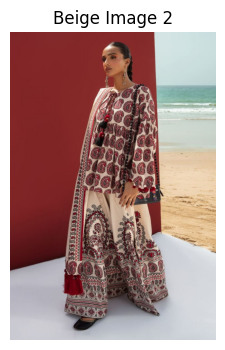

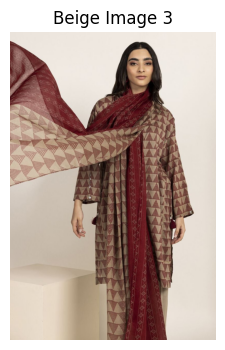

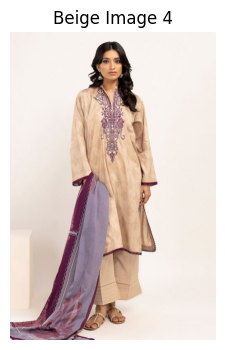

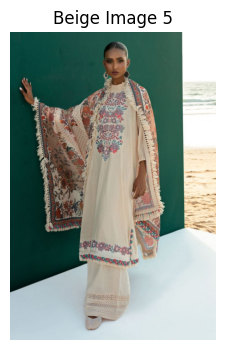

Displaying images from /content/drive/MyDrive/Khaadi/Grey


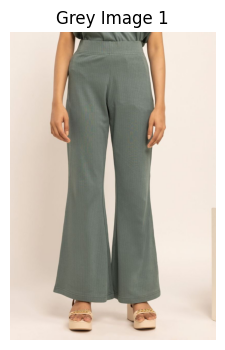

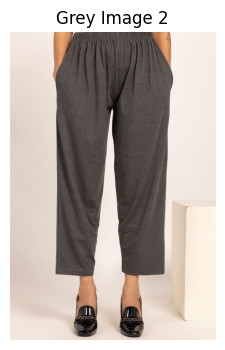

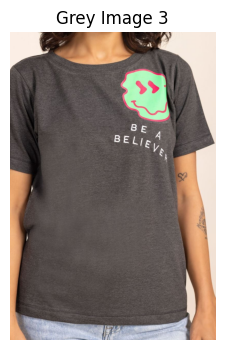

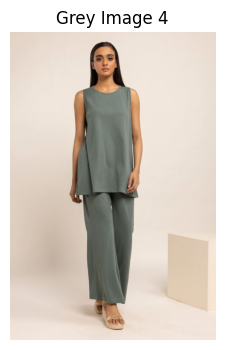

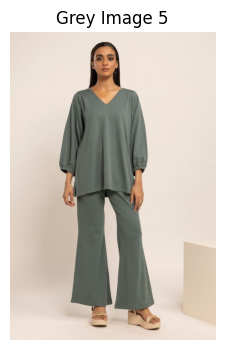

In [56]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Folder path where color directories are located
folder_path = '/content/drive/MyDrive/Khaadi'

# Function to load and display images from a folder
def display_images_from_folder(folder, colors):
    for color in colors:
        color_path = os.path.join(folder, color)
        print(f"Displaying images from {color_path}")

        # List all files in the color directory
        files = os.listdir(color_path)

        # Display up to 3 images from each color directory
        num_images_to_display = min(5, len(files))

        # Load and display each image
        for i in range(num_images_to_display):
            img_path = os.path.join(color_path, files[i])
            img = Image.open(img_path)

            # Display the image
            plt.figure(figsize=(4, 4))
            plt.imshow(img)
            plt.title(f"{color} Image {i+1}")
            plt.axis('off')
            plt.show()

# Call the function to display images from each color directory in all_colors_array
display_images_from_folder(folder_path, all_colors_array)


FileUpload(value={}, accept='image/*', description='Upload')

/content/drive/MyDrive/Khaadi/Beige
['beige_01.jpg', 'beige_02.jpg', 'beige_03.jpg', 'beige_06.jpg', 'beige_04.jpg', 'beige_05.jpg', 'beige_07.jpg', 'beige_08.jpg', 'beige_09.jpg', 'beige_10.jpg', 'beige_12.jpg', 'beige_11.jpg', 'beige_13.jpg', 'beige_15.jpg', 'beige_14.jpg', 'beige_16.jpg', 'beige_21.jpg', 'beige_20.jpg', 'beige_19.jpg', 'beige_17.jpg', 'beige_18.jpg', 'beige_22.jpg', 'beige_23.jpg']
/content/drive/MyDrive/Khaadi/Black
['black_01.jpg', 'black_02.jpg', 'black_03.jpg', 'black_08.jpg', 'black_05.jpg', 'black_04.jpg', 'black_06.jpg', 'black_07.jpg', 'black_13.jpg', 'black_09.jpg', 'black_14.jpg', 'black_11.jpg', 'black_17.jpg', 'black_12.jpg', 'black_10.jpg', 'black_15.jpg', 'black_20.jpg', 'black_19.jpg', 'black_16.jpg', 'black_18.jpg', 'black_24.jpg', 'black_21.jpg', 'black_23.jpg', 'black_25.jpg', 'black_22.jpg', 'black_33.jpg', 'black_30.jpg', 'black_31.jpg', 'black_34.jpg', 'black_32.jpg', 'black_29.jpg', 'black_26.jpg', 'black_28.jpg', 'black_27.jpg', 'black_37.jpg'